In [1]:
import os
os.chdir("../../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
seed_everything(0)

In [4]:
# use_contrastive = True
use_contrastive = False
num_tasks = 5
# num_epochs = 20
num_epochs = 40
# num_epochs = 100


data_cfg = {
    "dataset_name": "mnist",
    "num_tasks": num_tasks,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    'remap_labels': True,
    'use_contrastive': use_contrastive,
    # 'with_replacement': True,
}
dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)


INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


In [5]:
seed_everything(7)
sender_dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


In [6]:
net_cfg = {
    'depth': 4,
    'layer_size': 64,
    'num_init_tasks': num_tasks,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': num_tasks,
    'dropout': 0.0,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': use_contrastive,
    'save_dir': 'test',
}

In [7]:
## MODULAR
NetCls = MLPSoftLLDynamic
LearnerCls = CompositionalDynamicER

## MONOLITHIC
NetCls = MLP
LearnerCls = NoComponentsER

sharing_cfg = DictConfig({
    "scorer": "cross_entropy",
    "num_queries": 4,
    "query_score_threshold": 0.0,
})
train_cfg = {
    # "num_epochs": 40,
    "num_epochs": num_epochs,
}

agent = RecvDataAgent(0, 0, dataset,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)

INFO:root:Agent: node_id: 0, seed: 0


In [8]:
chosen_tasK_id = 0
# chosen_tasK_id = 1
# chosen_target_label = 1
chosen_target_label = 1
dataset = filter_dataset_by_label(sender_dataset.trainset[chosen_tasK_id], chosen_target_label)
X_source = dataset.tensors[0]
X_source.shape

torch.Size([68, 1, 28, 28])

In [9]:
# somehow modern pytorch NN weights are initialized such that
# untrained models map all inputs to the same label.
# Here, the most confidence task decoder is selected although
# all decoders are 100% consistent.
rank_and_pseudo_label(agent, X_source)

task_id 0
predicted_labels tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



task_id 1
predicted_labels tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



task_id 2
predicted_labels tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



task_id 3
predicted_labels tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

(tensor(2),
 tensor(1),
 {'predicted_label_matrix': tensor([[ 0, 68],
          [ 0, 68],
          [ 0, 68],
          [68,  0],
          [68,  0]]),
  'confidences_matrix': tensor([[0.0000, 0.5239],
          [0.0000, 0.5091],
          [0.0000, 0.5430],
          [0.5248, 0.0000],
          [0.5110, 0.0000]]),
  'total_scores': tensor([[ 0.0000, 68.5239],
          [ 0.0000, 68.5090],
          [ 0.0000, 68.5430],
          [68.5248,  0.0000],
          [68.5109,  0.0000]])})

In [10]:
# before additional data
for t in range(num_tasks):
    agent.train(t)

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: avg	loss: 0.691	acc: 0.524
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: avg	loss: 0.691	acc: 0.524
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: avg	loss: 0.693	acc: 0.508
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: avg	loss: 0.693	acc: 0.508
INFO:root:epochs: 0, training task: 2
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: 2	loss: 0.700	acc: 0.481
INFO:root:	task: avg	loss: 0.695	acc: 0.499
INFO:root:epochs: 0, training task: 2
INFO:root:	task: 0	loss: 0.691	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: 2	loss: 0.700	acc: 0.481
INFO:root:	task: avg	loss: 0.695	acc: 0.499
INFO

In [11]:
# label again after training.
# FUNNY: after 20 epochs, the model 
best_task_id, best_label, debug_info = rank_and_pseudo_label(agent, X_source)
best_task_id, best_label, debug_info

task_id 0
predicted_labels tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])



task_id 1
predicted_labels tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])



task_id 2
predicted_labels tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1])



task_id 3
predicted_labels tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1

(tensor(4),
 tensor(0),
 {'predicted_label_matrix': tensor([[60,  8],
          [51, 17],
          [24, 44],
          [17, 51],
          [63,  5]]),
  'confidences_matrix': tensor([[0.9791, 0.8288],
          [0.9735, 0.9131],
          [0.9063, 0.9180],
          [0.7518, 0.9663],
          [0.9531, 0.8849]]),
  'total_scores': tensor([[60.9791,  8.8288],
          [51.9735, 17.9131],
          [24.9063, 44.9180],
          [17.7518, 51.9663],
          [63.9531,  5.8849]])})

In [12]:
debug_info['total_scores'].max(dim=1)

torch.return_types.max(
values=tensor([60.9791, 51.9735, 44.9180, 51.9663, 63.9531]),
indices=tensor([0, 0, 1, 1, 0]))

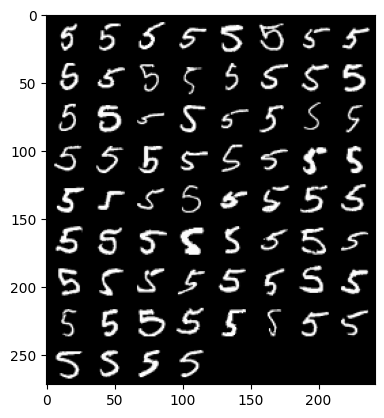

In [13]:
plt.imshow(make_grid(X_source).permute(1,2,0));

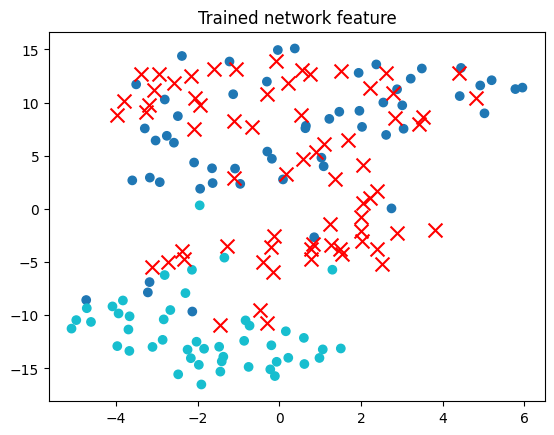

In [24]:
task_id = 4
with torch.no_grad():
    agent.net.eval()
    Xval_sender, yval_sender = agent.dataset.valset[task_id].tensors
    Xval_train_embed = agent.net.encode(Xval_sender.to(agent.net.device), task_id=0).detach().cpu()
    qX_embed = agent.net.encode(X_source.to(agent.net.device), task_id=0).detach().cpu()
    # Xval_train_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval_train_embed)
    combined_embed = torch.cat([Xval_train_embed, qX_embed], dim=0)
    combined_embed_2D = TSNE(n_components=2, random_state=0).fit_transform(combined_embed)

    # Split the 2D embeddings for plotting
    Xval_train_embedded_2D = combined_embed_2D[:len(Xval_train_embed)]
    qX_embed_2D = combined_embed_2D[len(Xval_train_embed):]


agent.net.train()

plt.scatter(Xval_train_embedded_2D[:, 0], Xval_train_embedded_2D[:, 1], c=yval_sender, cmap='tab10')
plt.scatter(qX_embed_2D[:, 0], qX_embed_2D[:, 1], c='r', marker='x', s=100)
plt.title("Trained network feature");

In [25]:
X_source_small = X_source[:10]
k =  5
# get k nearest neighbors to X_source_small using cosine similarity
# on the embedding space.

from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Embedding
with torch.no_grad():
    agent.net.eval()
    Xval_sender_embed = agent.net.encode(Xval_sender.to(agent.net.device), task_id=task_id).detach().cpu()
    X_source_small_embed = agent.net.encode(X_source_small.to(agent.net.device), task_id=task_id).detach().cpu()
    y_pred = torch.argmax(agent.net(X_source_small.to(agent.net.device), task_id=task_id).detach().cpu(), dim=1)

# Step 2: Compute cosine similarities
similarities = cosine_similarity(X_source_small_embed, Xval_sender_embed)

# Step 3: Find k nearest neighbors
nearest_neighbors_indices = similarities.argsort(axis=1)[:, -k:]



In [26]:
## TODO: what??? There's a bug. The y_pred is much more diverse than suggested by the nearest neighbors.
## Look like the decoder just kinda sucks LOLLLL.

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


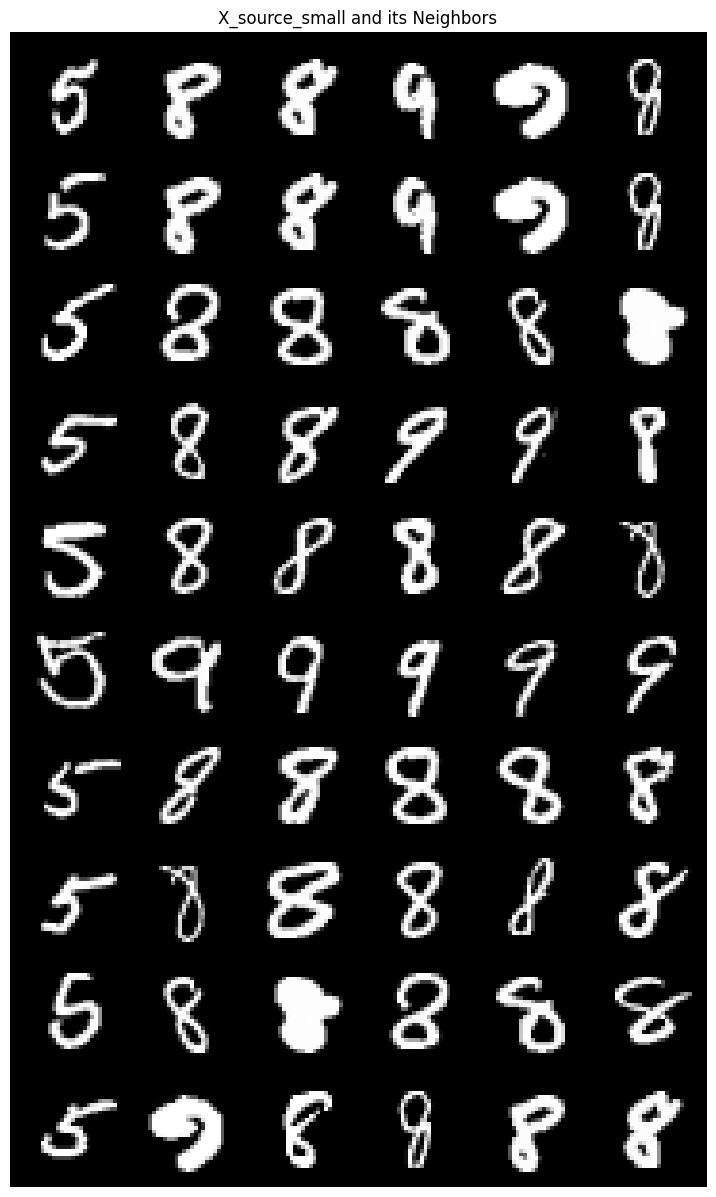

In [27]:
## NOTE: the embedding is much diverse than the outputted decoder on cross entropy.
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Step 1: For each image in X_source_small, concatenate it with its k nearest neighbors.
visual_rows = []
for img, neighbor_indices in zip(X_source_small, nearest_neighbors_indices):
    neighbors = Xval_sender[neighbor_indices]
    row = torch.cat([img.unsqueeze(0), neighbors])
    visual_rows.append(row)

# Step 2: Stack all the concatenated rows
to_display = torch.cat(visual_rows)

# Step 3: Use make_grid to create a visualization
grid = vutils.make_grid(to_display, nrow=k+1, padding=2, normalize=True, range=(0, 1), scale_each=True)
print(y_pred)
# Step 4: Display using matplotlib
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))
plt.title('X_source_small and its Neighbors')
plt.axis('off')
plt.show()
